In [1]:
using SBMLToolkit, ModelingToolkit, DifferentialEquations, StochasticDiffEq
using Plots
using DataFrames
using CSV
using Random
using Distributions
using SBML
using SymbolicUtils
using StaticArrays
using Catalyst
using AdvancedMH
using MCMCChains
using MCMCChainsStorage
using AbstractMCMC
# import StatsPlots
using ArviZ
using HDF5
using Distances

using Particles
using ParticlesDE
using StaticDistributions

include("utilities.jl")
include("plot_functions.jl")
include("sir_model.jl");

# SIR-model
In this notebook we gonna implement the simple SIR model to perform experiemnts with the particle filter. The state space is $\mathbb{R}^2_+$, where the first component of $X$ are the susceptibles and the second are the infecteed people. 
For implementational ease we consider the scaled process on the state-space $[0,1]^2$.

In [2]:
# overall model settings

N = 100
u0 = [0.96; 0.04]
tspan = (0.0, 100.0)
p = [0.2; 0.05];

In [3]:
# define the functions reaction system, which underly the ODE and the SDE representation
@parameters β γ
@variables t s(t) i(t)
D = Differential(t)

drift = [D(s) ~ -β*s*i,
      D(i) ~ β*s*i-γ*i]

diff = [sqrt(β*s*i/N), 
        -sqrt(β*s*i/N)+sqrt(γ*i/N)]

diffusion = [sqrt(β*s*i/N) 0 ;-sqrt(β*s*i/N) sqrt(γ*i/N)]

@named sde = SDESystem(drift, diffusion, t, [s, i], [β, γ])

u0map = [s => 0.96, i => 0.04]
parammap = [β=>0.2, γ=>0.05]

In [4]:
# define solver and its arguments for the SDE 
solve_alg = PosEM()
solve_kwargs = (dt=1e-2,)
nothing

In [5]:
# define and solve the SDE
problem = SDEProblem(sde, u0map, tspan, parammap);
sol = solve(problem, solve_alg; solve_kwargs...);

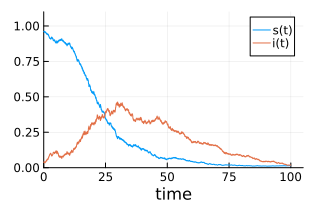

In [6]:
sde_plt = plot(sol, ylim=(0.0, 1.1), xlim=(0.0, 105.0), xlabel="time", size=(0.5*width_px,0.5*2/3*width_px))

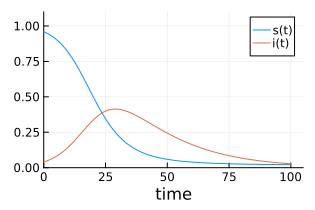

In [10]:
# define and solve the ODE
@named ode = ODESystem(drift, t, [s, i], [β, γ])
ode_problem=ODEProblem(ode, u0map, tspan, parammap);
ode_sol = solve(ode_problem; dense=true, solve_kwargs...);
ode_plt = Plots.plot(ode_sol, ylim=(0.0, 1.1), xlim=(0.0, 105.0), xlabel="time",
    size=(width_px/2, width_px/3))

In [ ]:
# define and solve the jump process
@variables t S(t) I(t) R(t)
rate₁   = β*S*I/N
affect₁ = [S ~ S - 1, I ~ I + 1]
rate₂   = γ*I
affect₂ = [I ~ I - 1]
j₁      = ConstantRateJump(rate₁,affect₁)
j₂      = ConstantRateJump(rate₂,affect₂)
@named js      = JumpSystem([j₁,j₂], t, [S,I], [β,γ])
u0 = [S => 96, I => 4]
prob = DiscreteProblem(js, u0, tspan, parammap)
jump_problem = JumpProblem(js, prob, Direct());
jump_sol = solve(jump_problem, SSAStepper()); # uses the Gillespie algorithm

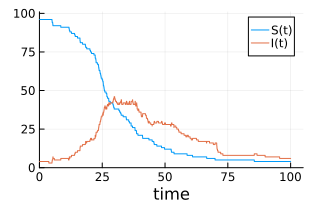

In [16]:
jump_plot=plot(jump_sol, xlabel="time", ylim=(0.0, 101), xlim=(0.0, 105.0), size=(0.5*width_px, 0.5*2/3*width_px))

So, we try as observations the following ($Y_1$=prevalence, $Y_2$=all with antibody) 
$$
Y_1(t)=i(t)+\varepsilon_1 \qquad Y_2(t)=1-s(t)+\varepsilon_2\qquad \varepsilon_i\sim\mathcal{N}(0,\zeta), 
$$
where $\zeta=0.02$

In [18]:
# define observation functions
nobs = 2

function prev(x, p, t)
    return x[2]
end

function infc_rel(x, p, t)
    return 1-x[1]
end

function fobs(x, p, t)
        return SIndependent(
            truncated(Normal(prev(x, p, t), 0.02; check_args=false), 0.0, nothing),
            truncated(Normal(infc_rel(x, p, t), 0.02; check_args=false), 0.0, nothing),
            )
end;

In [19]:
# generate synthetic data and store it
true_params = problem.p
tobs = [i*10 for i in range(start=1, step=1, stop=10)];
yobs = [rand(fobs(sol(t), true_params, t)) for t in tobs];

yobs = collect(SVector{2, Union{Missing, Float64}}, yobs);

# y_data = DataFrame(y1 = [yobs[i][1] for i in collect(1:10)], y2 = [yobs[i][2] for i in collect(1:10)])
# CSV.write("./data/sir_model_SparseSynth.csv", y_data)

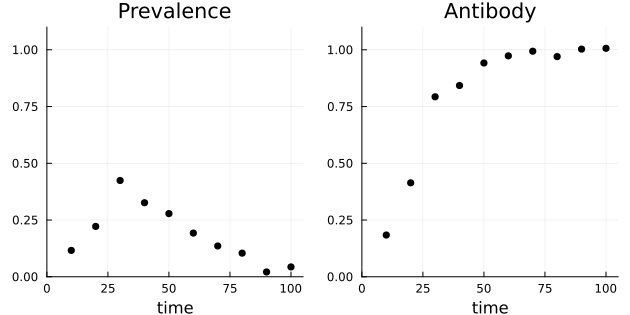

In [22]:
# plotting the synthetically generated data

plt1 = scatter(tobs, y_load[!,"y1"],
    xlim=(0.0,105.0),
    ylim=(0.0,1.1),
    xlabel="time",
    title="Prevalence",
    leg=false,
    markershape =:circle,
    markercolor=:black,
    markerstrokecolor=:black)

plt2 = scatter(tobs, y_load[!,"y2"],
    xlim=(0.0,105.0),
    ylim=(0.0, 1.1),
    xlabel="time",
    title="Antibody",
    leg=false,
    markershape =:circle,
    markercolor=:black,
    markerstrokecolor=:black)

l=@layout [a{0.5w} b{0.5w}]

plot(plt1,plt2, size=(width_px, 0.5*width_px))

The whole model is stored in `sir_model.jl`.

In [8]:
# specify the number of particles and its corresponding likelihood function 
nparticles = 100

llh_no_priors = LogLikelihood_NoGradient(ssm, real_data; nparticles=nparticles)
no_priors_model = DensityModel(llh_no_priors)
llh_priors = likelihood(nparticles)
priors_model = DensityModel(llh_priors);

In [9]:
# does 50 runs and computes the empirical variance of the log-likelihood estimator
violin_plt = my_plot_llh_vs_nparticles(ssm, problem.p, real_data, [10,20,30,40,50,60,70,80,90,100])

data: [
  "violin with fields name, type, and y",
  "violin with fields name, type, and y",
  "violin with fields name, type, and y",
  "violin with fields name, type, and y",
  "violin with fields name, type, and y",
  "violin with fields name, type, and y",
  "violin with fields name, type, and y",
  "violin with fields name, type, and y",
  "violin with fields name, type, and y",
  "violin with fields name, type, and y"
]

layout: "layout with fields margin, template, violinmode, xaxis, and yaxis"

This indicates that a minimum amount of 60 particles should be used for this model to keep the variance below one.

In [10]:
# get one simulation of the hidden process
hidden, obs=rand(ssm, problem.p, length(tobs));
# plot the filtering distributions and its coverage of the hidden trajectory of 200 runs of a Bootstrap Filter 
plot_filter(ssm, problem.p, hidden, obs, [1,2]; nparticles=100,)

data: [
  "scatter with fields line, mode, name, type, x, and y",
  "scatter with fields line, mode, name, showlegend, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, showlegend, type, x, and y",
  "scatter with fields line, mode, name, type, x, and y",
  "scatter with fields line, mode, name, showlegend, type, x, and y",
  "scatter with fields fill, fillcolor, line, mode, name, showlegend, type, x, and y",
  "scatter with fields marker, mode, name, type, x, and y",
  "scatter with fields marker, mode, name, type, x, and y"
]

layout: "layout with fields margin and template"

The second plot shows that 100 particles are able to cover the underlying dynamics.

### Looking at particle ancestor traces

In [72]:
# define and run one instance of the Bootstrap Filter
ssm = SDEStateSpaceModel(problem, initial_state, fobs, nobs, tobs, solve_alg; solve_kwargs...);

bf = BootstrapFilter(ssm, real_data)
pf = SMC(bf, problem.p, 80, ParticleHistoryLength(; didresample=FullHistory(), ancestors=FullHistory(),
                                                                        logCnorm=StaticFiniteHistory{1}()),
            AdaptiveResampling(SystematicResampling(),0.5),);
offlinefilter!(pf);

[4, 4, 5, 6, 10, 16, 22, 22, 42, 42, 80]

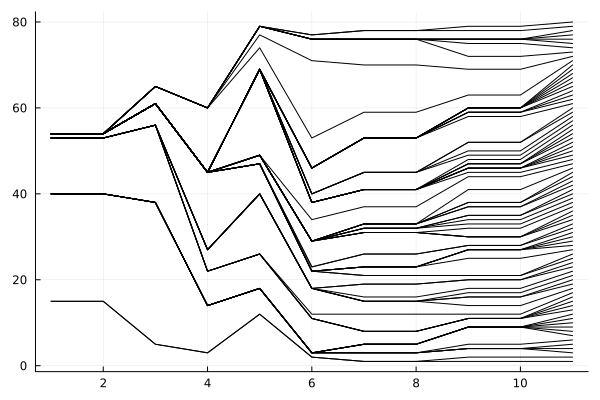

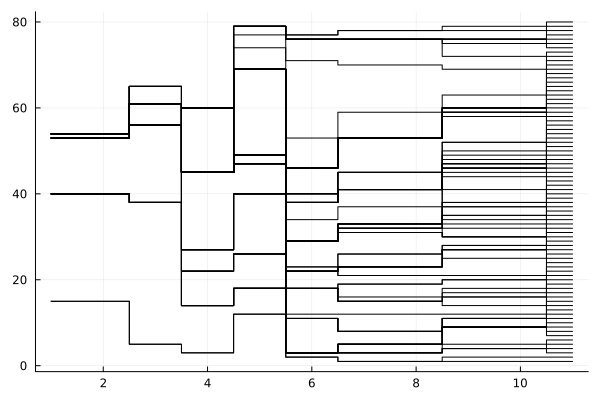

In [78]:
# print the path of particles ancestors as a genealogical tree
plotlyjs()
print(unique_ancestors_at_previous_times(pf.history_pf.ancestors))
plot_ancestor_tree(pf.history_pf.ancestors)

### Sampling

In [311]:
init_par = rand(prior_dist)
cov = [0.05, 0.01]
spl = RWMH([Normal(0.0, cov[1]), Normal(0.0, cov[2])]) # using the normal MH algorithm implemented in Julia
chain = sample(priors_model, spl, AbstractMCMC.MCMCSerial(), 100, 3; init_params=[init_par, init_par, init_par], param_names=["beta", "gamma"], chain_type=Chains)

Sampling (Chain 1 of 3): 100%|██████████████████████████| Time: 0:00:05
Sampling (Chain 2 of 3): 100%|██████████████████████████| Time: 0:00:07
Sampling (Chain 3 of 3): 100%|██████████████████████████| Time: 0:00:07


Chains MCMC chain (100×3×3 Array{Float64, 3}):

Iterations        = 1:1:100
Number of chains  = 3
Samples per chain = 100
parameters        = beta, gamma
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat 
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64 

        beta    0.2263    0.0236     0.0014    0.0038   34.4715    1.0583
       gamma    0.0503    0.0050     0.0003    0.0007   39.3707    1.0393

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        beta    0.1687    0.2084    0.2238    0.2472    0.2612
       gamma    0.0424    0.0471    0.0497    0.0536    0.0606


Abs. err. between post. mean and true values:[-0.02633647903590744, -0.0003123865173560586]3×2 DataFrame
 Row │ MSJD         acceptance_rate 
     │ Float64      Any             
─────┼──────────────────────────────
   1 │ 0.000135152  0.873418
   2 │ 0.000215134  0.78481
   3 │ 0.000253569  0.696203
2×7 DataFrame
 Row │ parameters  mean       std        naive_se     mcse         ess      rhat    
     │ Symbol      Float64    Float64    Float64      Float64      Float64  Float64 
─────┼──────────────────────────────────────────────────────────────────────────────
   1 │ beta        0.226336   0.0236157  0.00136346   0.00382349   34.4715  1.05834
   2 │ gamma       0.0503124  0.0050267  0.000290217  0.000692479  39.3707  1.03933

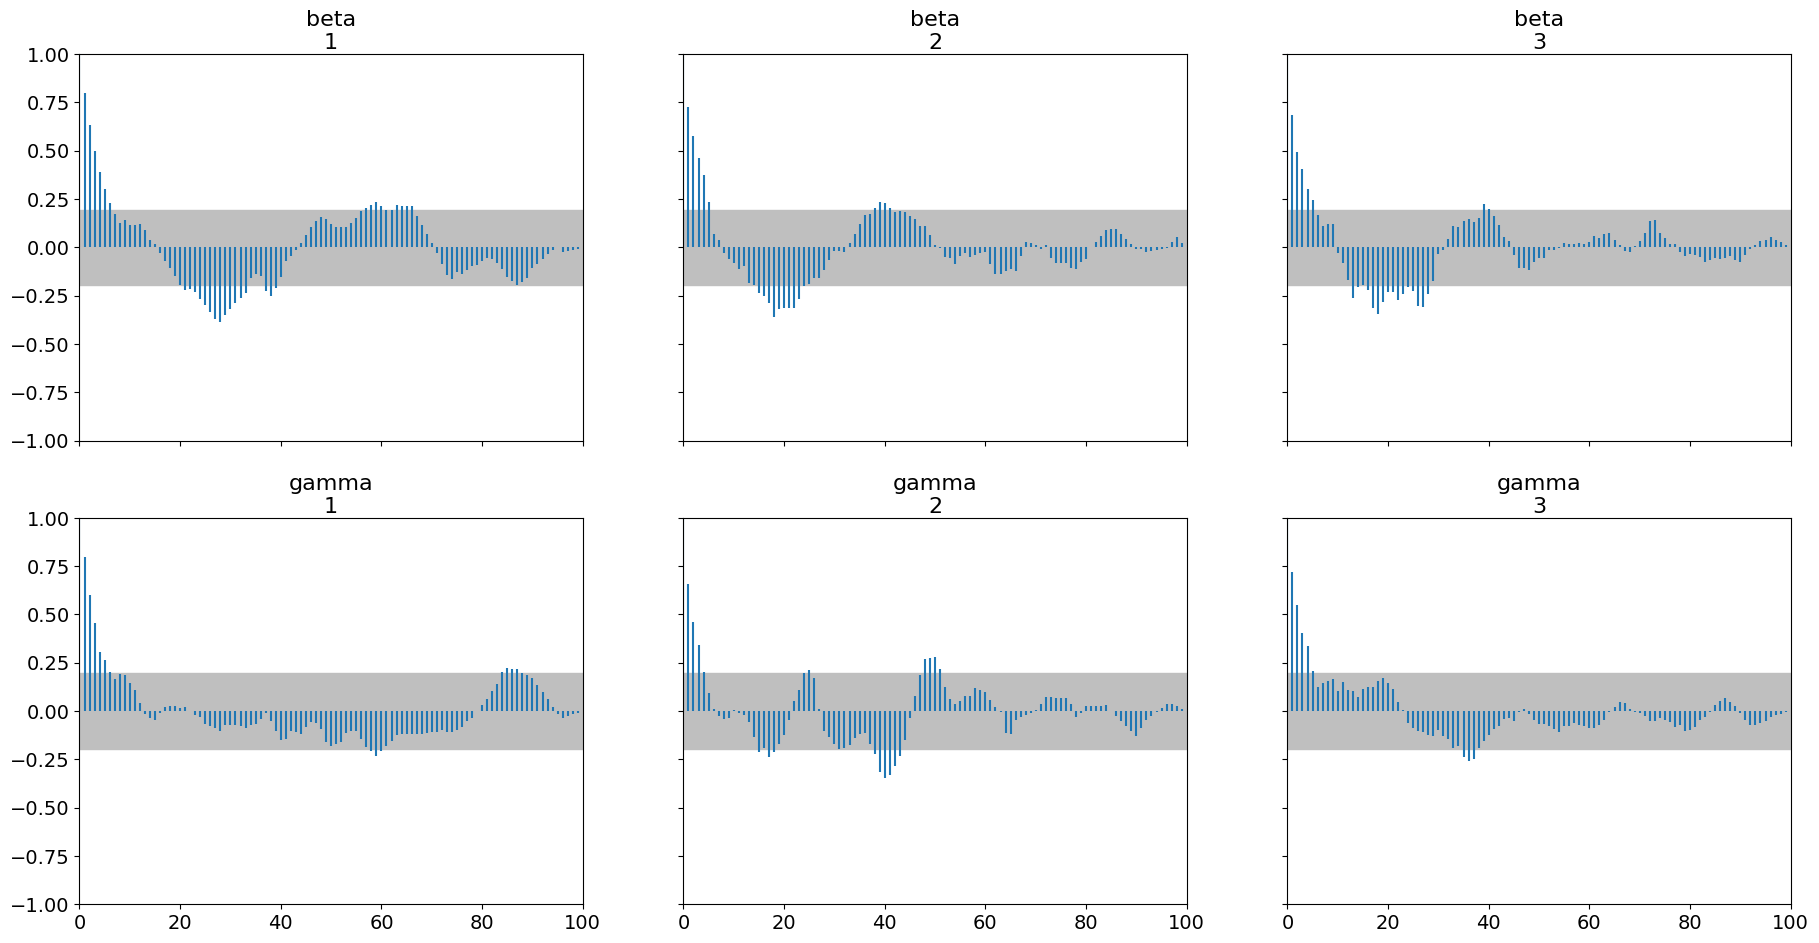

In [312]:
evaluate_chain(problem, chain, tobs, y_load, ["beta", "gamma"];burn_in=20)

## Outlook
The chain does not move a lot, which could be due to the proposal covariance, I chose. So in the `SIR-model-inference.ipynb` I will use the adaptive pypesto sampler to circumvent the tedious tuning of the proposal covariance.

In `SIR-model-likelihoods.ipynb` I investigate more on the likelihood landscape of the model, to check the model ability and identifiability of the parameters.
Lastly, `plotting.ipynb` was used to create the figures used in the thesis.